<a href="https://colab.research.google.com/github/kharit74/OtusCV/blob/main/detectronVSultralytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-34phevfu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-34phevfu
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6438679 sha256=46c6a8d6ee7c7615f889ab62307cd36213d7411cda2def7563fb47a73eeaa72c
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbtxkuub/wheels/17/d9/40/60db98e485aa9455

In [ ]:
import torch, torchvision
import random
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import os
import cv2
import json
import numpy as np

from detectron2.utils.visualizer import Visualizer
print(torch.__version__, torch.cuda.is_available())

import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
im = cv2.imread('/content/drive/MyDrive/Data/HM17/otus_basketball_dataset/images_train/000256.jpeg')
cv2_imshow(im)

2.6.0+cu124 True


In [ ]:
model_name = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_cfg()
# add project-specific config (e.g., TensorMask)
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[05/26 07:25:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


model_final_f6e8b1.pkl: 243MB [00:01, 134MB/s]                           
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


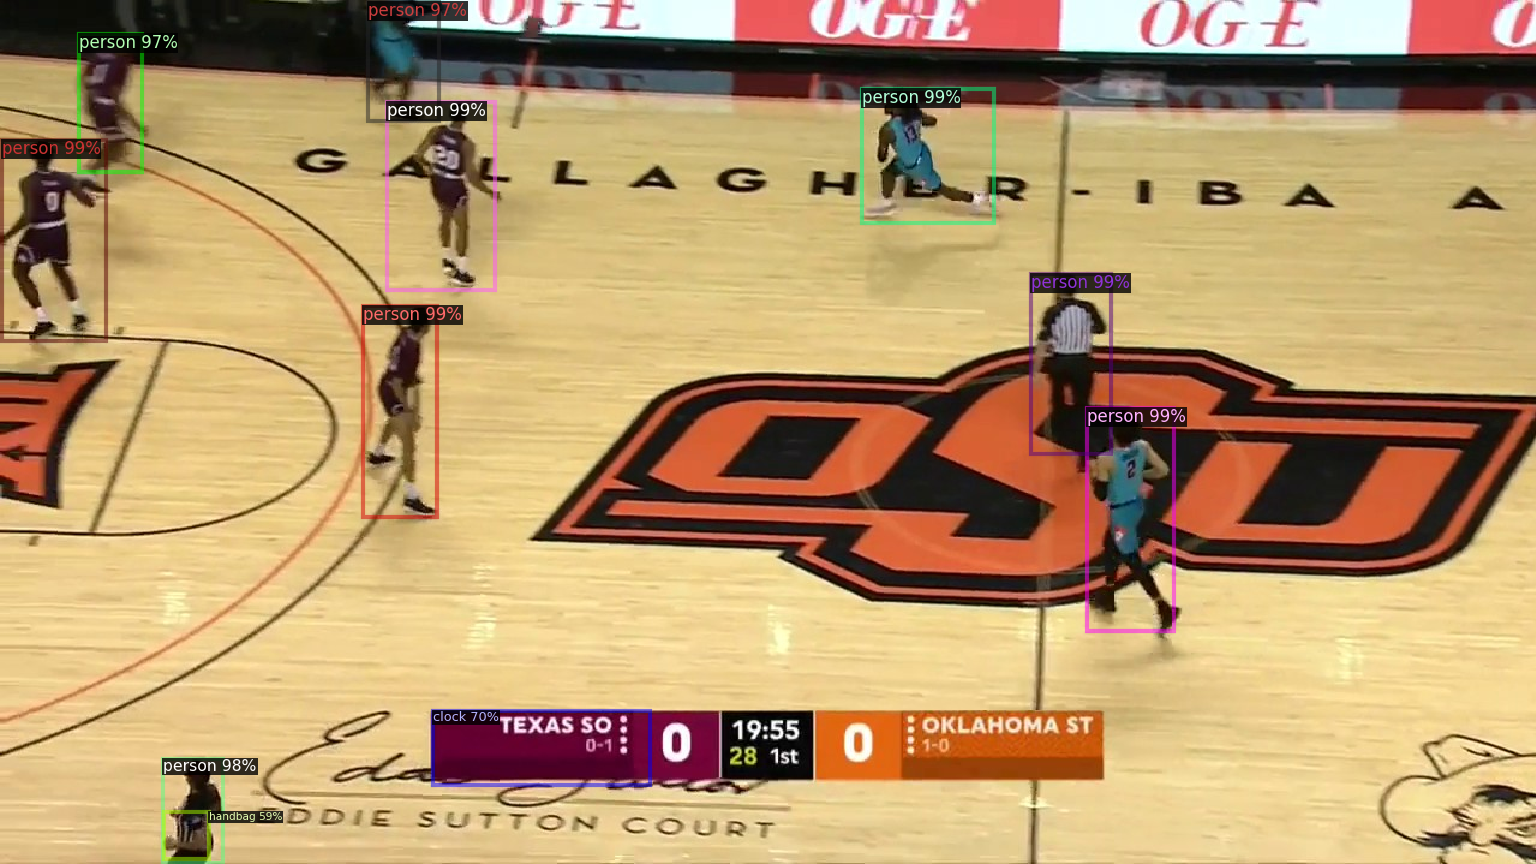

In [ ]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:

from detectron2.structures import BoxMode

def get_images_dicts(img_dir, annotation_file):
    json_file = os.path.join(img_dir, "..", annotation_file)  # Путь к аннотациям
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, (filename_key, img_info) in enumerate(imgs_anns.items()):
        record = {}

        # Путь к изображению в соответствующей подпапке (images_train/images_test)
        images_subdir = "images_train" if "train" in annotation_file else "images_test"
        filename = os.path.join(img_dir, "..", images_subdir, filename_key)

        if not os.path.exists(filename):
            print(f"{filename} - не существует.")
            continue

        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for obj_id, obj_info in img_info.items():
            if obj_id == "null":
                continue

            # Конвертация в абсолютные координаты
            x_center_norm, y_center_norm, w_norm, h_norm = obj_info["box"]
            x_center = x_center_norm * width
            y_center = y_center_norm * height
            w = w_norm * width
            h = h_norm * height

            obj = {
                "bbox": [
                    x_center,  # x_min
                    y_center,  # y_min
                    x_center + w,  # x_max
                    y_center + h   # y_max
                ],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": obj_info["team"],  # 0 или 1
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts



In [ ]:
# Регистрация датасетов
from detectron2.data import DatasetCatalog, MetadataCatalog
# Удаляем все зарегистрированные датасеты
for name in list(DatasetCatalog.list()):
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)


data_root = "/content/drive/MyDrive/Data/HM17/otus_basketball_dataset"

# Для тренировочных данных
DatasetCatalog.register("basketball_train", lambda: get_images_dicts(
    os.path.join(data_root, "images_train"),
    "anno_train.json"
))
MetadataCatalog.get("basketball_train").set(thing_classes=["team_0", "team_1"])

# # Для тестовых данных
# DatasetCatalog.register("basketball_test", lambda: get_images_dicts(
#     os.path.join(data_root, "images_test"),
#     "anno_test.json"
# ))
# MetadataCatalog.get("basketball_test").set(thing_classes=["team_0", "team_1"])

basketball_metadata = MetadataCatalog.get("basketball_train")

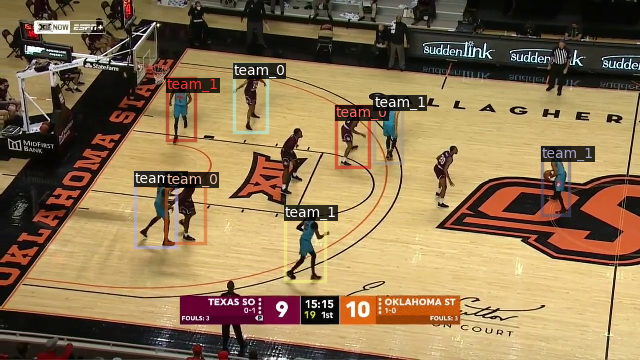

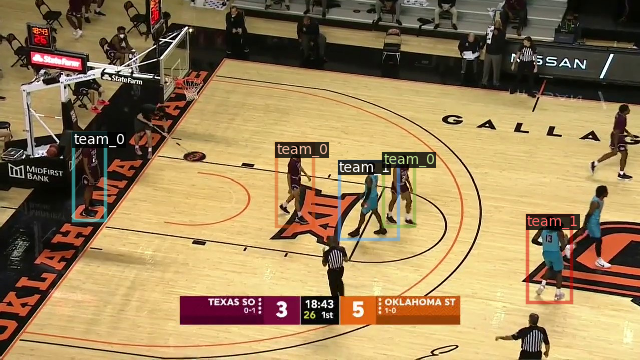

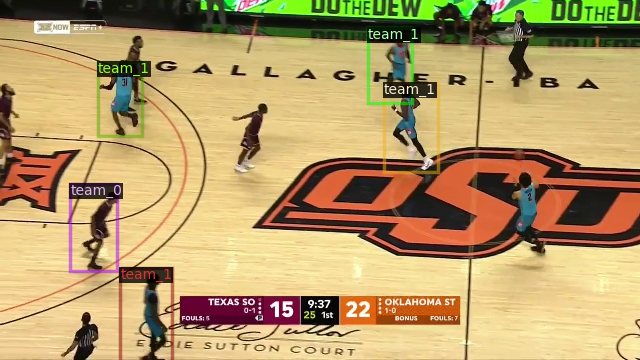

In [ ]:
dataset_dicts = get_images_dicts(
    os.path.join(data_root, "images_train"),
    "anno_train.json"
)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

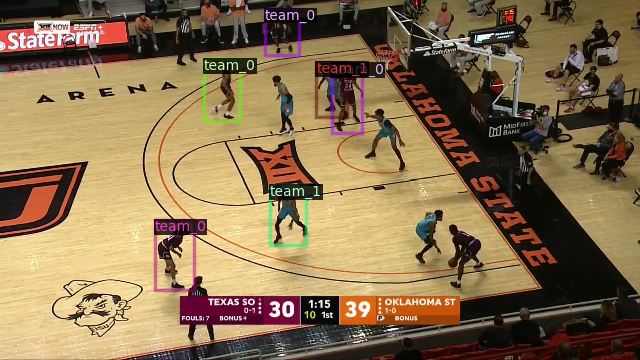

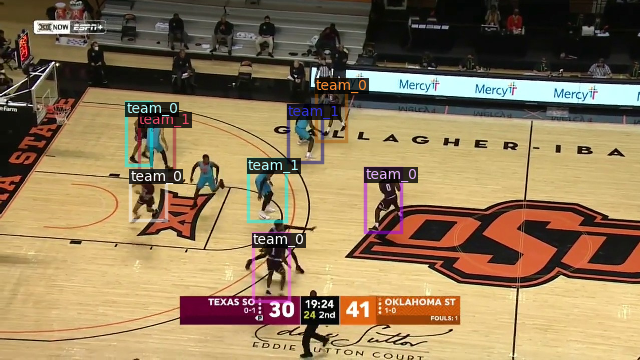

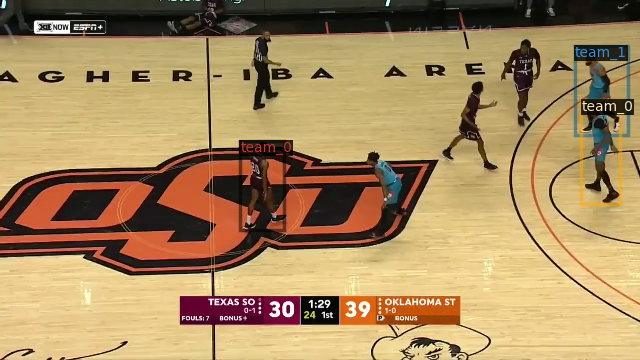

In [ ]:
dataset_dicts = get_images_dicts(
    os.path.join(data_root, "images_test"),
    "anno_test.json"
)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("basketball_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/26 09:12:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/26 09:13:03 d2.engine.train_loop]: Starting training from iteration 0
[05/26 09:13:18 d2.utils.events]:  eta: 0:03:29  iter: 19  total_loss: 1.893  loss_cls: 1.024  loss_box_reg: 0.7694  loss_rpn_cls: 0.08193  loss_rpn_loc: 0.03044    time: 0.7187  last_time: 0.7720  data_time: 0.0285  last_data_time: 0.0101   lr: 1.6068e-05  max_mem: 3738M
[05/26 09:13:33 d2.utils.events]:  eta: 0:03:15  iter: 39  total_loss: 1.747  loss_cls: 0.8993  loss_box_reg: 0.7697  loss_rpn_cls: 0.06116  loss_rpn_loc: 0.02826    time: 0.7307  last_time: 0.7754  data_time: 0.0090  last_data_time: 0.0075   lr: 3.2718e-05  max_mem: 3738M
[05/26 09:13:48 d2.utils.events]:  eta: 0:03:01  iter: 59  total_loss: 1.588  loss_cls: 0.7196  loss_box_reg: 0.7722  loss_rpn_cls: 0.07441  loss_rpn_loc: 0.02788    time: 0.7341  last_time: 0.6483  data_time: 0.0077  last_data_time: 0.0062   lr: 4.9367e-05  max_mem: 3738M
[05/26 09:14:03 d2.utils.events]:  eta: 0:02:47  iter: 79  total_loss: 1.413  loss_cls: 0.6031  loss_box_

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/26 09:21:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


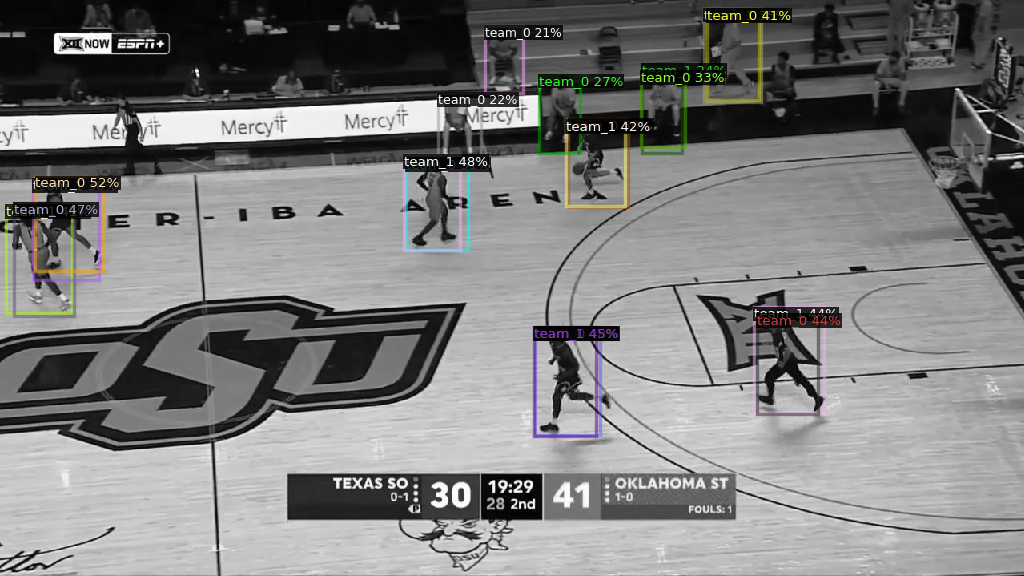

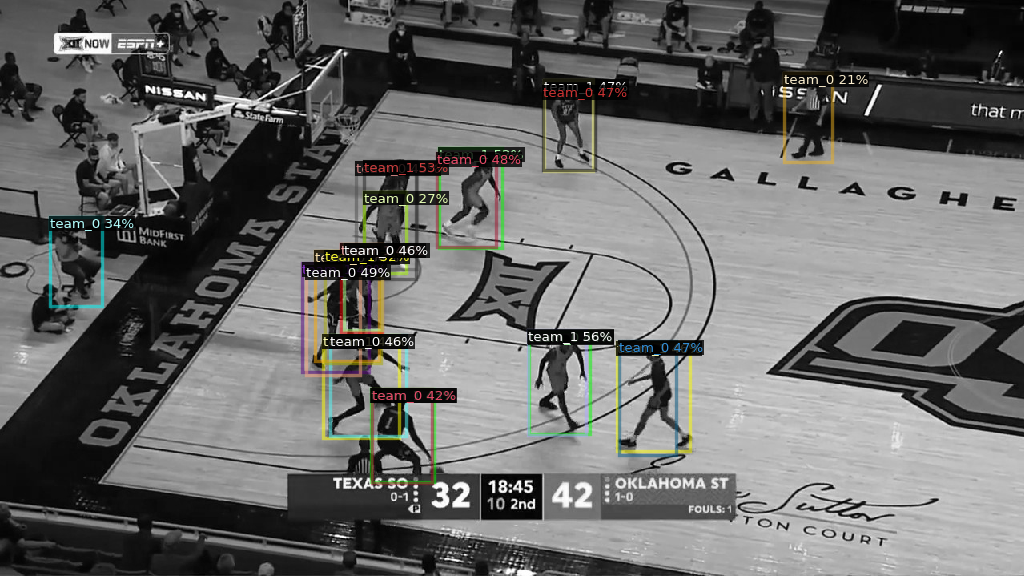

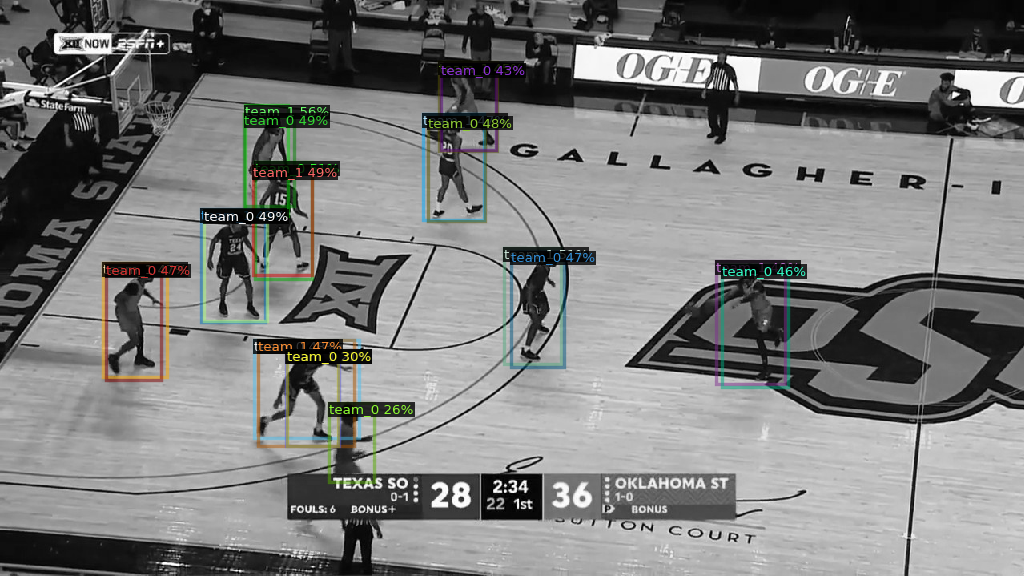

In [ ]:
# Укажи правильные пути к данным
data_root = "/content/drive/MyDrive/Data/HM17/otus_basketball_dataset"

# 1. Получаем тестовые данные
test_dataset_dicts = get_images_dicts(
    img_dir=os.path.join(data_root, "images_test"),
    annotation_file="anno_test.json")

# 2. Визуализируем предсказания для 3 случайных изображений
for d in random.sample(test_dataset_dicts, 3):
    # Загрузка изображения
    im = cv2.imread(d["file_name"])

    # Предсказание модели
    outputs = predictor(im)

    # Визуализация
    v = Visualizer(
        im[:, :, ::-1],  # Конвертация BGR -> RGB
        metadata=basketball_metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )

    # Рисуем предсказания поверх изображения
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Показываем результат (для Google Colab)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# evaluator = COCOEvaluator("balloon_val", output_dir="./output")
# val_loader = build_detection_test_loader(cfg, "balloon_val")
# print(inference_on_dataset(predictor.model, val_loader, evaluator))

# 1. Создаем evaluator для тестового датасета
evaluator = COCOEvaluator(
    "basketball_train",  # Имя зарегистрированного тестового датасета
    output_dir="./output",  # Папка для сохранения метрик
    tasks=("bbox",)  # Задача: детекция (можно добавить "segm" для сегментации)
)

# 2. Загружаем тестовые данные
test_loader = build_detection_test_loader(
    cfg,  # Конфиг вашей модели
    "basketball_train"  # Имя тестового датасета
)

# 3. Запускаем оценку
metrics = inference_on_dataset(
    predictor.model,  # Модель для оценки
    test_loader,
    evaluator
)

# 4. Выводим результаты
print("COCO Metrics:", metrics)

[05/26 09:29:36 d2.evaluation.coco_evaluation]: Trying to convert 'basketball_train' to COCO format ...
[05/26 09:29:36 d2.data.datasets.coco]: Converting annotations of dataset 'basketball_train' to COCO format ...)
[05/26 09:29:40 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/26 09:29:41 d2.data.datasets.coco]: Conversion finished, #images: 400, #annotations: 2516
[05/26 09:29:41 d2.data.datasets.coco]: Caching COCO format annotations at './output/basketball_train_coco_format.json' ...
[05/26 09:29:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/26 09:29:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/26 09:29:45 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[05/26 09:29:45 d2.data.common]: Serialized dataset takes 0.23 MiB
[05/26 09:29:4

In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import ultralytics
import json
import os
from pathlib import Path
import shutil
from ultralytics import YOLO
ultralytics.checks()

from IPython.display import Image

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.6/107.7 GB disk)


In [ ]:
# Конфигурация путей
drive_path = "/content/drive/MyDrive/Data/HM17"
dataset_name = "otus_basketball_dataset"
yolo_dataset_name = "otus_basketball_yolo"

base_path = f"{drive_path}/{dataset_name}"
yolo_path = f"{drive_path}/{yolo_dataset_name}"

# Создание структуры папок YOLO
Path(f"{yolo_path}/train/images").mkdir(parents=True, exist_ok=True)
Path(f"{yolo_path}/train/labels").mkdir(parents=True, exist_ok=True)
Path(f"{yolo_path}/val/images").mkdir(parents=True, exist_ok=True)
Path(f"{yolo_path}/val/labels").mkdir(parents=True, exist_ok=True)

In [ ]:
def convert_dataset(json_path, img_source_dir, yolo_img_dir, yolo_label_dir):
    # Проверка существования исходной директории
    if not os.path.exists(img_source_dir):
        raise FileNotFoundError(f"Source image directory {img_source_dir} not found!")

    with open(json_path) as f:
        data = json.load(f)

    total_images = 0
    missing_images = []

    for img_name, objects in data.items():
        # Пропуск null объектов
        if "null" in objects:
            del objects["null"]

        # Обработка изображений
        src_img = os.path.join(img_source_dir, img_name)
        dst_img = os.path.join(yolo_img_dir, img_name)

        # Если изображение существует
        if os.path.exists(src_img):
            # Копируем изображение
            shutil.copy(src_img, dst_img)
            total_images += 1
        else:
            missing_images.append(img_name)
            continue

        # Создание аннотаций
        txt_filename = os.path.splitext(img_name)[0] + ".txt"
        txt_path = os.path.join(yolo_label_dir, txt_filename)

        with open(txt_path, 'w') as txt_file:
            for obj_id, obj in objects.items():
                class_id = obj["team"]
                x_center, y_center, width, height = obj["box"]
                txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    print(f"Processed: {total_images} images")
    if missing_images:
        print(f"Missing {len(missing_images)} images:")
        print("\n".join(missing_images[:5]))


In [ ]:
# Обработка тренировочных данных
print("Processing training data:")
convert_dataset(
    json_path=f"{base_path}/anno_train.json",
    img_source_dir=f"{base_path}/images_train",
    yolo_img_dir=f"{yolo_path}/train/images",
    yolo_label_dir=f"{yolo_path}/train/labels"
)

# Обработка тестовых данных
print("\nProcessing validation data:")
convert_dataset(
    json_path=f"{base_path}/anno_test.json",
    img_source_dir=f"{base_path}/images_test",
    yolo_img_dir=f"{yolo_path}/val/images",
    yolo_label_dir=f"{yolo_path}/val/labels"
)

Processing training data:
Processed: 400 images

Processing validation data:
Processed: 100 images


In [ ]:
# Проверка созданных данных
def check_dataset(yolo_path):
    for split in ["train", "val"]:
        images_dir = f"{yolo_path}/{split}/images"
        labels_dir = f"{yolo_path}/{split}/labels"

        images = list(Path(images_dir).glob("*"))
        labels = list(Path(labels_dir).glob("*"))

        print(f"\n{split.upper()}:")
        print(f"Found {len(images)} images")
        print(f"Found {len(labels)} labels")

        if len(images) != len(labels):
            print("Warning: Mismatch between images and labels count!")

check_dataset(yolo_path)


TRAIN:
Found 400 images
Found 400 labels

VAL:
Found 100 images
Found 100 labels


In [ ]:
# Создание data.yaml
data_yaml = f"""
path: {yolo_path}
train: train/images
val: val/images

names:
  0: team0
  1: team1

nc: 2
"""

with open(f"{yolo_path}/data.yaml", 'w') as f:
    f.write(data_yaml)

In [ ]:
# Обучение модели
model = YOLO("yolo11n.pt")  # Загрузка предобученной модели

try:
    results = model.train(
        data=f"{yolo_path}/data.yaml",
        epochs=50,
        imgsz=640,
        batch=16,
        optimizer='Adam',
        lr0=0.001,
        device= 'cpu'
    )
except Exception as e:
    print(f"Training error: {e}")
    print("Verify dataset structure and paths:")
    !tree {yolo_path} -L 3

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Data/HM17/otus_basketball_yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, 

train: Scanning /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/labels.cache... 400 images, 0 backgrounds, 6 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/images/020017.jpeg: ignoring corrupt image/label: negative label values [ -0.0036567 -0.00010637]
train: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/images/029147.jpeg: ignoring corrupt image/label: negative label values [ -0.0029727]
train: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/images/037892.jpeg: ignoring corrupt image/label: negative label values [-0.00035214]
train: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/images/040155.jpeg: ignoring corrupt image/label: negative label values [ -0.0032212]
train: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/images/047533.jpeg: ignoring corrupt image/label: negative label values [ -0.0011074]
train: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/train/images/055446.jpeg: ignoring corrupt image/label: negative label values [ -0.0015945]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, bl


val: Scanning /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/val/labels.cache... 100 images, 0 backgrounds, 2 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/val/images/081921.jpeg: ignoring corrupt image/label: negative label values [ -0.0020796]
val: /content/drive/MyDrive/Data/HM17/otus_basketball_yolo/val/images/094774.jpeg: ignoring corrupt image/label: negative label values [  -0.008668]
Plotting labels to runs/detect/train4/labels.jpg... 


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/25 [00:02<?, ?it/s]


KeyboardInterrupt: 